# $F=0\rightarrow F=1$ MOT temperature with the OBE

This example covers single atom evolution in a 3D MOT with no gravity using the optical Bloch equations.  It highlights an interesting effect of the 3D lattice that is inherent in all MOTs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import lmfit
from pylcp.common import progressBar

## Define the problem

Laser beams, magnetic field, and Hamiltonian.

In [2]:
laser_det = 0
det = -2.5
s = 1.25
transform = True

laserBeams = pylcp.conventional3DMOTBeams(
    s=s, delta=0., beam_type=pylcp.infinitePlaneWaveBeam
)
#laserBeams.beam_vector[2:7] = [] # Delete the y,z beams
#laserBeams.num_of_beams = 2

alpha = 1e-4
magField = pylcp.quadrupoleMagneticField(alpha)

# Hamiltonian for F=0->F=1
H_g, muq_g = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
H_e, muq_e = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
hamiltonian = pylcp.hamiltonian(H_g, -det*np.eye(3)+H_e, muq_g, muq_e, d_q, mass=100)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                transform_into_re_im=transform)

## Calculate the equilibrium force
Let's try looking at a single force profile along each axis, $\hat{x}$, $\hat{y}$, and $\hat{z}$:

In [3]:
z = np.arange(-5.01, 5.01, 0.25)

R = {}
R['x'] = [2*z/alpha, np.zeros(z.shape), np.zeros(z.shape)]
R['y'] = [np.zeros(z.shape), 2*z/alpha, np.zeros(z.shape)]
R['z'] = [np.zeros(z.shape), np.zeros(z.shape), z/alpha]

V = {
    'x':[0.0*np.ones(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
    'y':[np.zeros(z.shape), 0.0*np.ones(z.shape), np.zeros(z.shape)],
    'z':[np.zeros(z.shape), np.zeros(z.shape), 0.0*np.ones(z.shape)]
}
for key in R:
    obe.generate_force_profile(
        R[key], V[key],
        name=key, deltat_tmax=2*np.pi*100, deltat_r=4/alpha,
        itermax=1000, progress_bar=True
    )

Completed in 10.03 s.                                              
Completed in 9.11 s.                                               
Completed in 10.50 s.                                              


Plot it up:

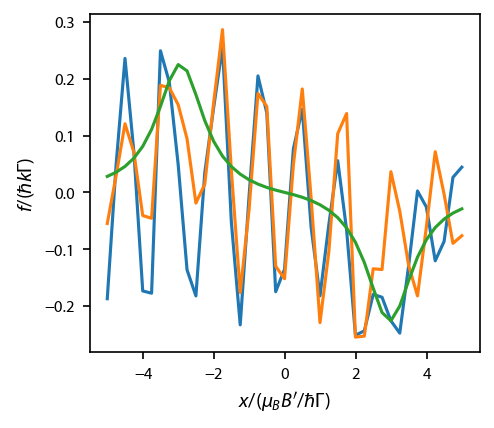

In [4]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(obe.profile):
    ax.plot(z, obe.profile[key].F[ii])

ax.set_xlabel('$x/(\mu_B B\'/\hbar \Gamma)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$');

Obviously there is something going on with the $\hat{x}$ and $\hat{y}$ directions.  The thing that is going on is interference in the optical lattice created by the 6 beams, and it is pronounced because the atom is not moving.  Let's repeat this exercise, but average over a period of the laser lattice.

### Average over the lattice

Again, note the the $x$ and $y$ calculation is a factor of 2 larger than $z$.

In [5]:
z = np.arange(-5.01, 5.01, 0.25)

R = {}
R['x'] = [2*z/alpha, np.zeros(z.shape), np.zeros(z.shape)]
R['y'] = [np.zeros(z.shape), 2*z/alpha, np.zeros(z.shape)]
R['z'] = [np.zeros(z.shape), np.zeros(z.shape), z/alpha]

V = {
    'x':[0.0*np.ones(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
    'y':[np.zeros(z.shape), 0.0*np.ones(z.shape), np.zeros(z.shape)],
    'z':[np.zeros(z.shape), np.zeros(z.shape), 0.0*np.ones(z.shape)]
}

Npts = 128
for key in R:
    progress = progressBar()
    for ii in range(Npts):
        obe.generate_force_profile(
            R[key] + 2*np.pi*(np.random.rand(3)-0.5).reshape(3,1), V[key],
            name=key + '_%d'%ii, deltat_tmax=2*np.pi*100, deltat_r=4/alpha,
            itermax=1000, progress_bar=False
        )
        progress.update((ii+1)/Npts)

Completed in 23:25.                                                 
Completed in 41:04.                                                 
Completed in 35:21.                                                 


Now take the average:

In [6]:
avgF = {}
for coord_key in R:
    avgF[coord_key] = np.sum([obe.profile[key].F for key in obe.profile if coord_key in key], axis=0)/Npts

Now plot it up:

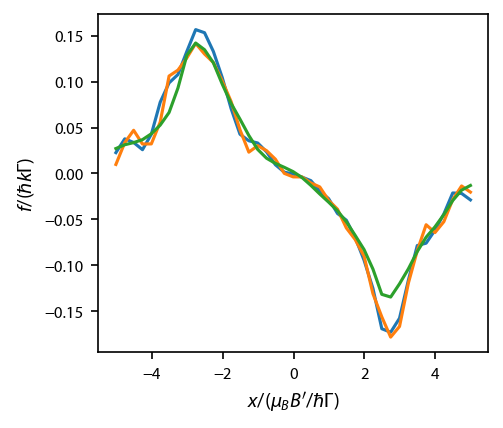

In [7]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(R):
    ax.plot(z, avgF[key][ii])
    
ax.set_xlabel('$x/(\mu_B B\'/\hbar \Gamma)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$');

That looks much better.

## Evolution without random scattering
One can choose various initial states.  Sometimes we appear to get trapped in some lattice if we choose our initial state poorly.

In [22]:
# %% Now try to evolve some initial state!
obe.v0 = np.array([0., 0., 0.])
obe.r0 = np.random.randn(3)/alpha
#obe.r0 = np.array([0., 100., 0.])
#obe.r0 = np.array([0., 0., 10.])
obe.set_initial_rho_from_rateeq()
# obe.set_initial_rho_equally()

t_span = [0, 1e4]

obe.evolve_motion(t_span,
                  progress_bar=True,
                  random_recoil=False
                 );

Completed in 1:00.                                                   


Plot it up:

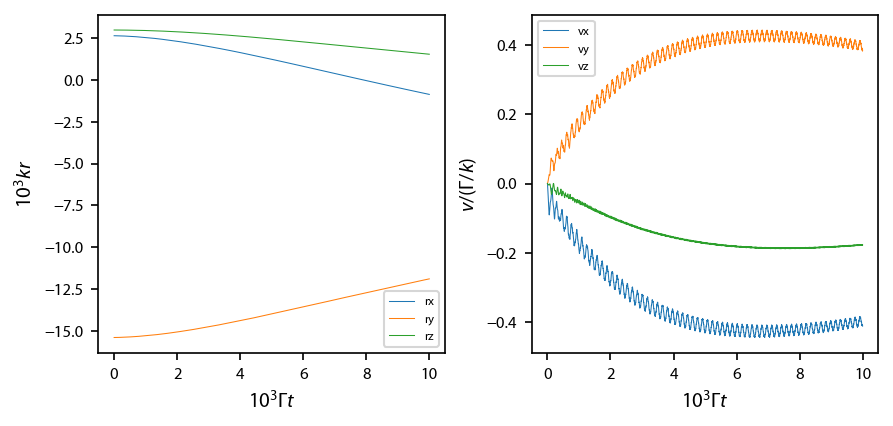

In [23]:
fig, ax = plt.subplots(1, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t/1e3, obe.sol.r[0]/1e3,
           label='rx', linewidth=0.5)
ax[0].plot(obe.sol.t/1e3, obe.sol.r[1]/1e3,
           label='ry', linewidth=0.5)
ax[0].plot(obe.sol.t/1e3, obe.sol.r[2]/1e3,
           label='rz', linewidth=0.5)
ax[0].legend(fontsize=6)
ax[0].set_xlabel('$10^3 \Gamma t$')
ax[0].set_ylabel('$10^3 kr$')

ax[1].plot(obe.sol.t/1e3, obe.sol.v[0],
           label='vx', linewidth=0.5)
ax[1].plot(obe.sol.t/1e3, obe.sol.v[1],
           label='vy', linewidth=0.5)
ax[1].plot(obe.sol.t/1e3, obe.sol.v[2],
           label='vz', linewidth=0.5)
ax[1].legend(fontsize=6)
ax[1].set_xlabel('$10^3 \Gamma t$')
ax[1].set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(wspace=0.25)

## Evolution with random scattering
First run another test simulation:

In [24]:
# %% Now try to evolve some initial state!
obe.v0 = 0.1*np.random.randn(3)
obe.r0 = 0.1*np.random.randn(3)/alpha
obe.set_initial_rho_from_rateeq()
# obe.set_initial_rho_equally()

t_span = [0, 5e4]

obe.evolve_motion(t_span,
                  progress_bar=True,
                  random_recoil=True
                 );

Completed in 5:40.                                                   


Plot it up:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


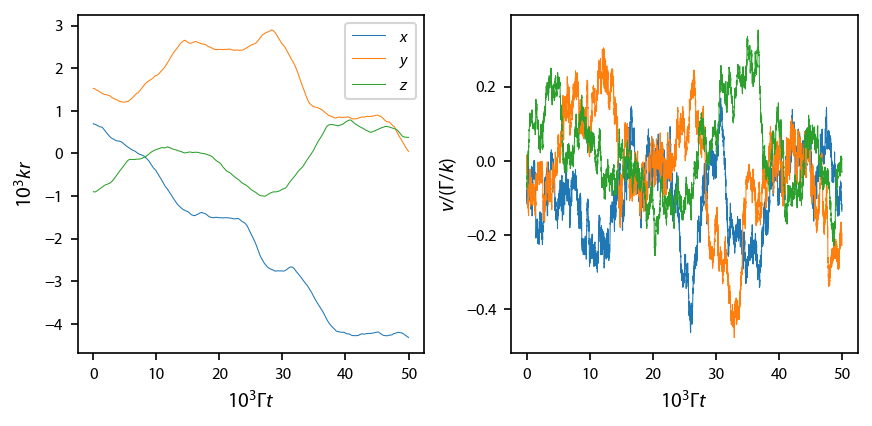

In [25]:
fig, ax = plt.subplots(1, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t/1e3, obe.sol.r[0]/1e3,
           label='$x$', linewidth=0.5)
ax[0].plot(obe.sol.t/1e3, obe.sol.r[1]/1e3,
           label='$y$', linewidth=0.5)
ax[0].plot(obe.sol.t/1e3, obe.sol.r[2]/1e3,
           label='$z$', linewidth=0.5)
ax[0].legend(fontsize=8)
ax[0].set_xlabel('$10^3 \Gamma t$')
ax[0].set_ylabel('$10^3 kr$')

ax[1].plot(obe.sol.t/1e3, obe.sol.v[0],
           label='vx', linewidth=0.5)
ax[1].plot(obe.sol.t/1e3, obe.sol.v[1],
           label='vy', linewidth=0.5)
ax[1].plot(obe.sol.t/1e3, obe.sol.v[2],
           label='vz', linewidth=0.5)
ax[1].set_xlabel('$10^3 \Gamma t$')
ax[1].set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(wspace=0.25)

Now run 96 atoms.  Again, we parallelize using `pathos`:

In [12]:
import pathos
if hasattr(obe, 'sol'):
    del obe.sol
    
tmax = 1e5
args = ([0, tmax], )
kwargs = {'t_eval':np.linspace(0, tmax, 5001),
          'random_recoil':True,
          'progress_bar':False,
          'max_scatter_probability':0.5,
          'record_force':False}

rscale = np.array([2, 2, 2])/alpha
roffset = np.array([0.0, 0.0, 0.0])
vscale = np.array([0.1, 0.1, 0.1])
voffset = np.array([0.0, 0.0, 0.0])

def generate_random_solution(x, tmax=1e5):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    np.random.rand(256*x)
    obe.set_initial_position(rscale*np.random.randn(3) + roffset)
    obe.set_initial_velocity(vscale*np.random.randn(3) + voffset)
    obe.set_initial_rho_from_rateeq()
    obe.evolve_motion(*args, **kwargs)
    
    return obe.sol

Natoms = 96
chunksize = 4
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    with pathos.pools.ProcessPool(nodes=4) as pool:
        sols += pool.map(generate_random_solution, range(chunksize))
    progress.update((jj+1)/int(Natoms/chunksize))

Completed in 4:23:31.                                               


Here's another potential way to parallelize.  We export a file that contains all the relevant data, and then execute the script `run_single_sim.py`.  That grabs the data from the pickled file, and executes the sim 12 times and dumps the results into pickled files.

```
import dill, os

if hasattr(obe, 'sol'):
    del obe.sol

tmax = 1e5
args = ([0, tmax], )
kwargs = {'t_eval':np.linspace(0, tmax, 5001),
          'random_recoil':True,
          'recoil_velocity':0.01,
          'progress_bar':True,
          'max_scatter_probability':0.5,
          'record_force':False}

rscale = np.array([2, 2, 2])/alpha
roffset = np.array([0.0, 0.0, 0.0])
vscale = np.array([0.1, 0.1, 0.1])
voffset = np.array([0.0, 0.0, 0.0])

with open('parameters.pkl', 'wb') as output:
    dill.dump(obe, output)
    dill.dump(args, output)
    dill.dump(kwargs, output)
    dill.dump((rscale, roffset, vscale, voffset), output)
```

This code reads the pickled files:

```
files = os.listdir(path='./sims/')

sols = []
for file in files:
    if file.endswith('.pkl'):
        with open('sims/'+ file, 'rb') as input:
            sols.append(dill.load(input))
            
print(len(sols))
```

No matter which way it was parallelized, let's plot up the result:

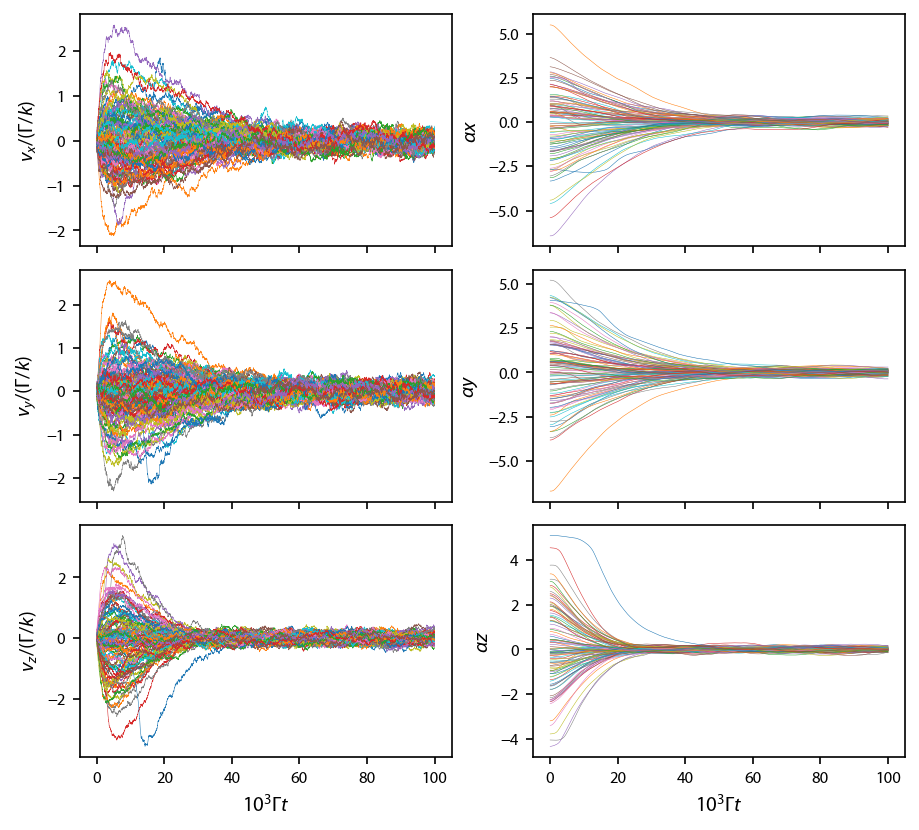

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(6.25, 2*2.75))
for sol in sols:
    for ii in range(3):
        ax[ii, 0].plot(sol.t/1e3, sol.v[ii], linewidth=0.25)
        ax[ii, 1].plot(sol.t/1e3, sol.r[ii]*alpha, linewidth=0.25)

"""for ax_i in ax[:, 0]:
    ax_i.set_ylim((-0.75, 0.75))
for ax_i in ax[:, 1]:
    ax_i.set_ylim((-4., 4.))"""
for ax_i in ax[-1, :]:
    ax_i.set_xlabel('$10^3 \Gamma t$')
for jj in range(2):
    for ax_i in ax[jj, :]:
        ax_i.set_xticklabels('')
for ax_i, lbl in zip(ax[:, 0], ['x','y','z']):
    ax_i.set_ylabel('$v_' + lbl + '/(\Gamma/k)$')
for ax_i, lbl in zip(ax[:, 1], ['x','y','z']):
    ax_i.set_ylabel('$\\alpha ' + lbl + '$')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.22)

Reconstruct the force:

In [14]:
for sol in sols:
    sol.F, sol.f_laser, sol.f_laser_q, sol.f_mag = obe.force(sol.r, sol.t, sol.rho, return_details=True)

Concatenate all the positions and velocities and forces:

In [15]:
allr = np.concatenate([sol.r[:, 500:].T for sol in sols]).T
allv = np.concatenate([sol.v[:, 500:].T for sol in sols]).T
allF = np.concatenate([sol.F[:, 500:].T for sol in sols]).T

Try to simulate what an image might look like (but we have to make it far more grainy because we have far fewer atoms):

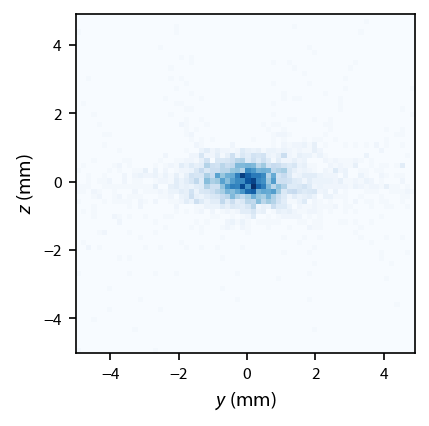

In [19]:
k = np.pi/2/780E-6
img, y_edges, z_edges = np.histogram2d(allr[1, ::100]/k, allr[2, ::100]/k, bins=[np.arange(-5., 5.01, 0.15), np.arange(-5., 5.01, 0.15)])

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img.T, origin='bottom',
               extent=(np.amin(y_edges), np.amax(y_edges),
                       np.amin(z_edges), np.amax(z_edges)),
               cmap='Blues',
               aspect='equal')

ax.set_xlabel('$y$ (mm)')
ax.set_ylabel('$z$ (mm)');

Let's evaluate the temperature as a function of time:

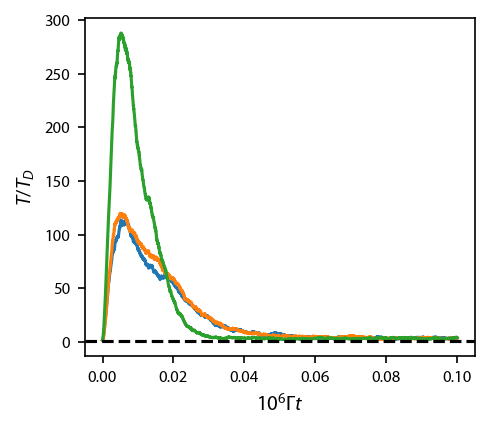

In [20]:
t_eval = kwargs['t_eval']
vs = np.nan*np.zeros((len(sols), 3, len(t_eval)))
for v, sol in zip(vs, sols):
    v[:, :sol.v.shape[1]] = sol.v
    
sigma_v = np.nanstd(vs, axis=0)
sigma_v.shape

fig, ax = plt.subplots(1, 1)
ax.plot(t_eval*1e-6, 2*sigma_v.T**2*hamiltonian.mass)
ax.axhline(1, color='k', linestyle='--')
ax.set_ylabel('$T/T_D$')
ax.set_xlabel('$10^6 \Gamma t$');

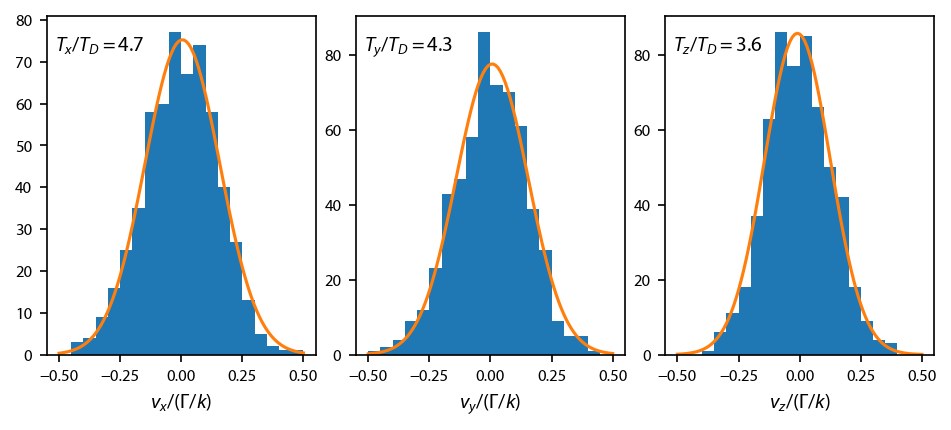

In [21]:
# Make a bunch of bins:
xb = np.arange(-0.5, 0.5001, 0.05)
lbls = ['x', 'y', 'z']   
fig, ax = plt.subplots(1, 3, figsize=(6.5, 2.75))

for ii, lbl in enumerate(lbls):
    # Make the histogram:
    ax[ii].hist(vs[:, ii, 2500::500].flatten(), bins=xb)
    
    # Extract the data:
    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(vs[:, ii, 2500::500].flatten(), bins=xb)[0]

    # Fit it:
    model = lmfit.models.GaussianModel()
    result = model.fit(y, x=x)
    
    # Plot up the fit:
    x_fit = np.linspace(-0.5, 0.5, 101)
    ax[ii].plot(x_fit, result.eval(x=x_fit))
    ax[ii].set_xlabel('$v_%s/(\Gamma/k)$'%lbl)
    
    # Add the temperature
    plt.text(0.03, 0.9,
             '$T_%s/T_D = %.1f$'%(lbl, 2*result.best_values['sigma']**2*hamiltonian.mass),
             transform=ax[ii].transAxes)
    
fig.subplots_adjust(left=0.07, wspace=0.15)